![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE, make_scorer
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from time import time
# Import any additional modules and start coding below

In [2]:
rental_info = pd.read_csv('rental_info.csv')
seed = 9

In [3]:
rental_transformed = rental_info.copy()
rental_transformed['rental_length_days'] = (pd.to_datetime(rental_transformed['return_date']) - pd.to_datetime(rental_transformed['rental_date'])).dt.total_seconds() / (24 * 3600)
rental_transformed = rental_transformed.drop(['rental_date', 'return_date'], axis=1)
rental_transformed['special_features'] = rental_transformed['special_features'].replace({'{': '', '}': '', '"': ''}, regex=True)
# special_features_dummies = rental_transformed['special_features'].str.get_dummies(sep=',')
# rental_transformed_full = pd.concat([rental_transformed, special_features_dummies], axis=1).drop('special_features', axis=1)
rental_transformed = rental_transformed.drop(['amount_2', 'rental_rate_2', 'length_2'], axis=1)

In [4]:
rental_transformed.isna().sum()

amount                0
release_year          0
rental_rate           0
length                0
replacement_cost      0
special_features      0
NC-17                 0
PG                    0
PG-13                 0
R                     0
rental_length_days    0
dtype: int64

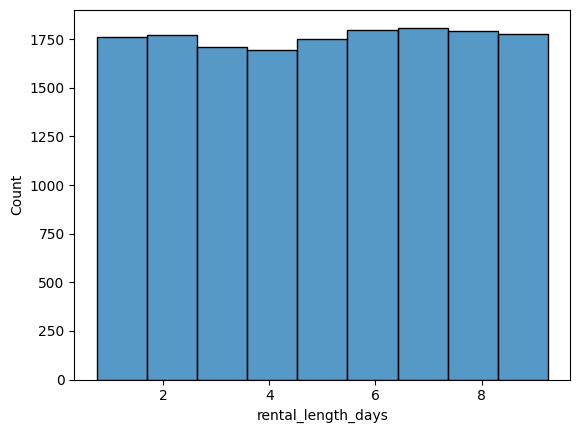

In [5]:
sns.histplot(rental_transformed, x='rental_length_days',bins=9)
plt.show()

In [6]:
X = rental_transformed.drop('rental_length_days', axis=1)
y = rental_transformed['rental_length_days'].values
cat_features = ['special_features']
num_features = [x for x in rental_transformed.columns if x not in ['special_features', 'rental_length_days']]

# Preprocessing

In [7]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features),
    ]
)
kf = KFold(10, shuffle=True, random_state=seed)

In [8]:
models = {
    'Lasso': {
        'model': Lasso(random_state=seed),
        'params': {
            'alpha': np.linspace(.01, 1., 11)
        }
    },
    'Ridge': {
        'model': Ridge(random_state=seed),
        'params': {
            'alpha': np.linspace(.01, 1., 11)
        }
    },
    'AdaBoostRegressor': {
        'model': AdaBoostRegressor(random_state=seed),
        'params': {
            'n_estimators': np.arange(100, 1000, 100),
            'learning_rate': np.linspace(.01, 1., 11)
        }
    },
    'BaggingRegressor': {
        'model': BaggingRegressor(random_state=seed),
        'params': {
            'n_estimators': np.arange(100, 1000, 100),
            'max_samples': np.linspace(.1, 1., 10),
            'max_features': np.linspace(.1, 1., 10)
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=seed),
        'params': {
            'n_estimators': np.arange(100, 1000, 100),
            'max_depth': np.arange(1, 10, 2),
            'min_samples_leaf': np.arange(1, 10, 2),
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=seed),
        'params': {
            'n_estimators': np.arange(100, 1000, 100),
            'max_depth': np.arange(1, 10, 2),
            'min_samples_leaf': np.arange(1, 10, 2),
        }
    }    
}

# Learning

## Pipelines

In [9]:
pipelines_and_grids = []
for name, config in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name.lower(), config['model'])
    ])
    param_grid = {f'{name.lower()}__{key}': value for key, value in config['params'].items()}
    pipelines_and_grids.append((name, pipeline, param_grid))

## Fitting

In [15]:
scores = []
for name, pipeline, param_grid in pipelines_and_grids:
    print(f'Running RandomizedSearchCV for {name}')
    start = time()
    cv = RandomizedSearchCV(n_jobs=-1, estimator=pipeline, param_distributions=param_grid, cv=kf, scoring='r2', return_train_score=True)
    cv.fit(X, y)
    for mean_score, params in  zip(cv.cv_results_['mean_test_score'], cv.cv_results_['params']):
        scores.append({
            'Model': name,
            'Mean Scores': mean_score,
            'Best Params': params
        })
    duration = round(time() - start, 1)
    m, s = int(duration // 60), round(duration % 60, 1)
    if m != 0:
        duration_printable = f'{m}m {s}s'
    else:
        duration_printable = f'{s}s'
    print(f'Finished {name} model in: {duration_printable}. Best score: {cv.best_score_}')

Running RandomizedSearchCV for Lasso
Finished Lasso model in: 2.7s. Best score: -0.590229643217962
Running RandomizedSearchCV for Ridge
Finished Ridge model in: 0.5s. Best score: -0.5920532554584567
Running RandomizedSearchCV for AdaBoostRegressor


KeyboardInterrupt: 

# Scores

In [14]:
model_scores = pd.DataFrame(scores)
model_scores.to_csv('model_scores_r2.csv', index=False)
px.box(model_scores, x='Model', y='Mean Scores').show()